In [29]:
import pickle
import emd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import sys
%matplotlib inline
import time
#%matplotlib qt

In [67]:
data_path = "C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/data/eeg_dataset_raw.pkl"
with open(data_path, "rb") as f:
    eeg_datasets_dict = pickle.load(f)

noise = 'pink' # ['burst,'pink','gaussian'] ->> NOISE TYPE

In [31]:
noisy_eeg_dataset = eeg_datasets_dict["datasets_artnoise_mne_format"]
raw_eeg_dataset = eeg_datasets_dict["datasets_mne_format"]

In [32]:
artifical_noise_eeg = noisy_eeg_dataset["noisy_scaled_eeg"]
channel_names = raw_eeg_dataset["channel_names"]
original_eeg = raw_eeg_dataset["original_scaled_eeg"]

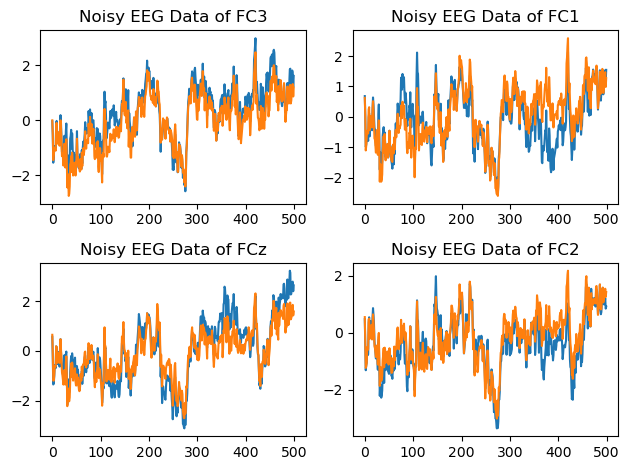

In [33]:
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(artifical_noise_eeg[i][:500])
    plt.title(f"Original EEG Data of {channel_names[i]}")
    plt.plot(original_eeg[i][:500])
    plt.title(f"Noisy EEG Data of {channel_names[i]}")
    plt.tight_layout()
plt.show()


# Decomposing into IMFs


In [34]:
# EMD IMFs
signal_imfs = []
for i, s in enumerate(artifical_noise_eeg):
    imfs = emd.sift.sift(s)
    signal_imfs.append(imfs)

In [35]:
# EEMD IMFs - Ensemble EMD
time = time.time()
ensemble_imfs = []
for i, signal in enumerate(artifical_noise_eeg):
    print(f"Signal {i+1} of {len(artifical_noise_eeg)}")
    signal_ensembles = []
    noise_to_use = [0.4,0.3,0.2,0.1,0.05] 
    for noise in noise_to_use:
        imfs = emd.sift.ensemble_sift(signal,nensembles=100, nprocesses=8, ensemble_noise=noise)
        print(f"Noise: {noise} done!")

        ensembles_dict = {
            "noise": noise,
            "imfs": imfs
        }
        signal_ensembles.append(ensembles_dict)
    ensemble_imfs.append(signal_ensembles)


Signal 1 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 2 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 3 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 4 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 5 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 6 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 7 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 8 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 9 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 0.05 done!
Signal 10 of 64
Noise: 0.4 done!
Noise: 0.3 done!
Noise: 0.2 done!
Noise: 0.1 done!
Noise: 

0.4
0.3
0.2
0.1
0.05


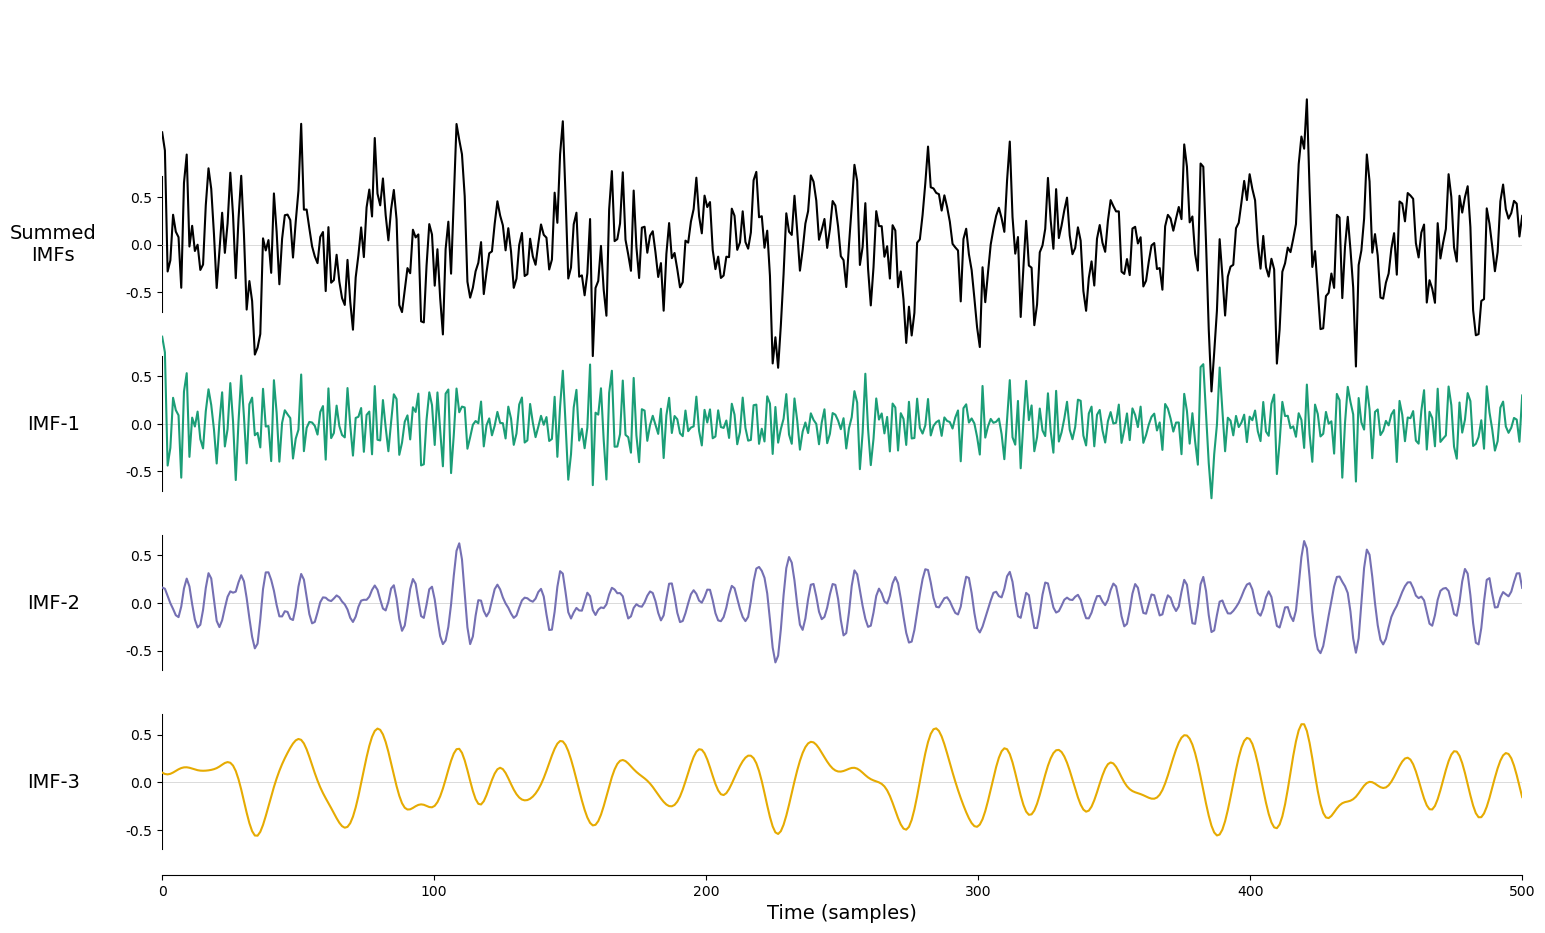

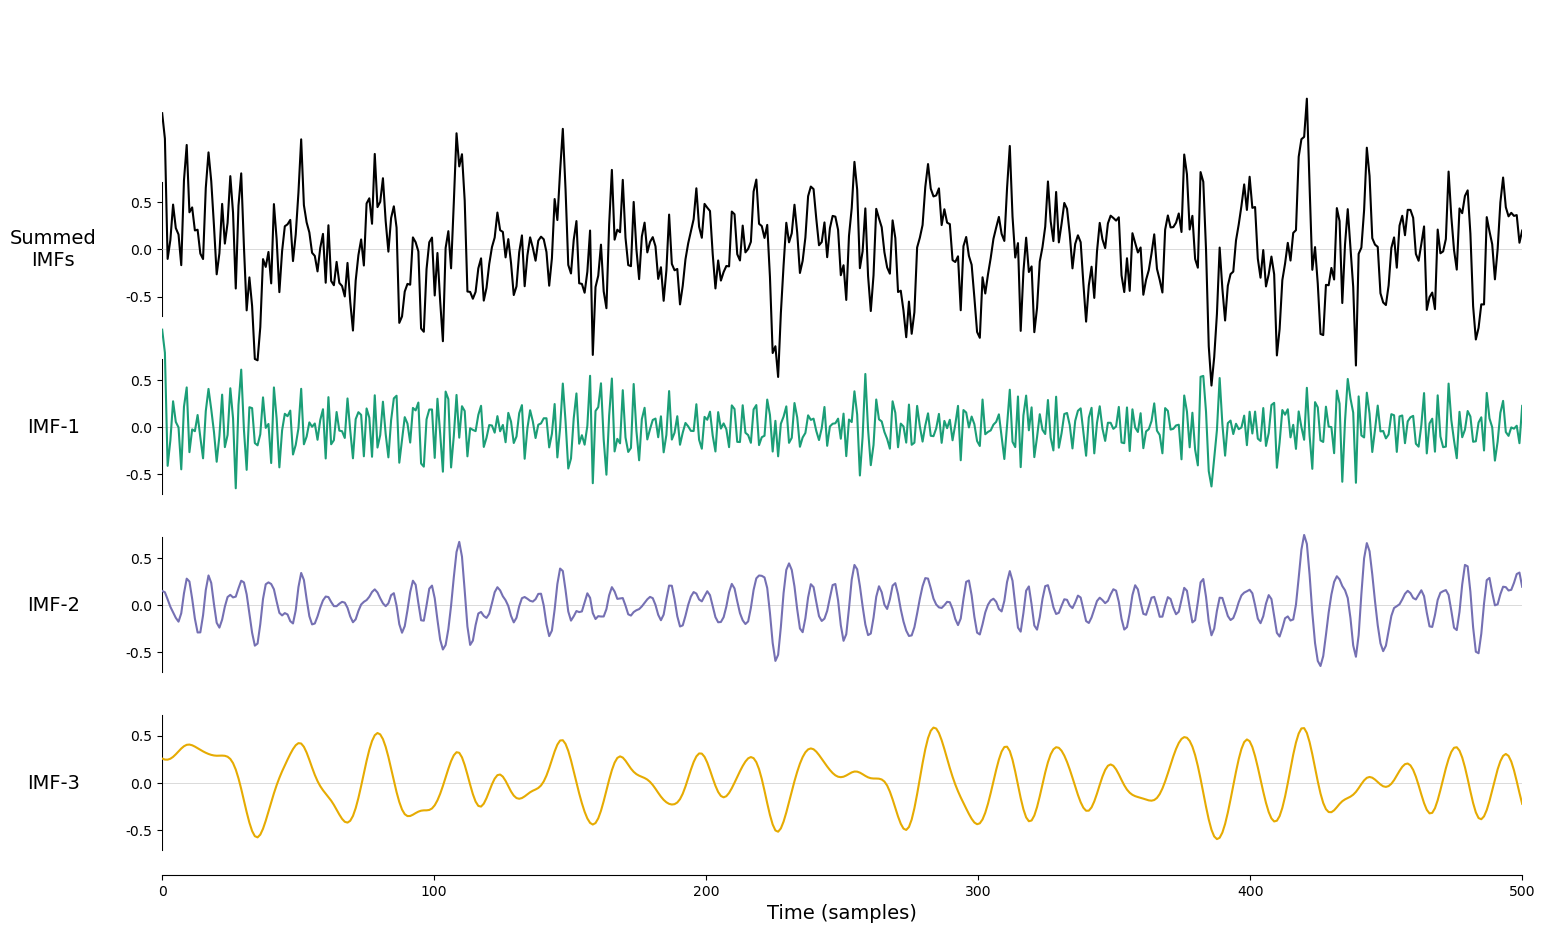

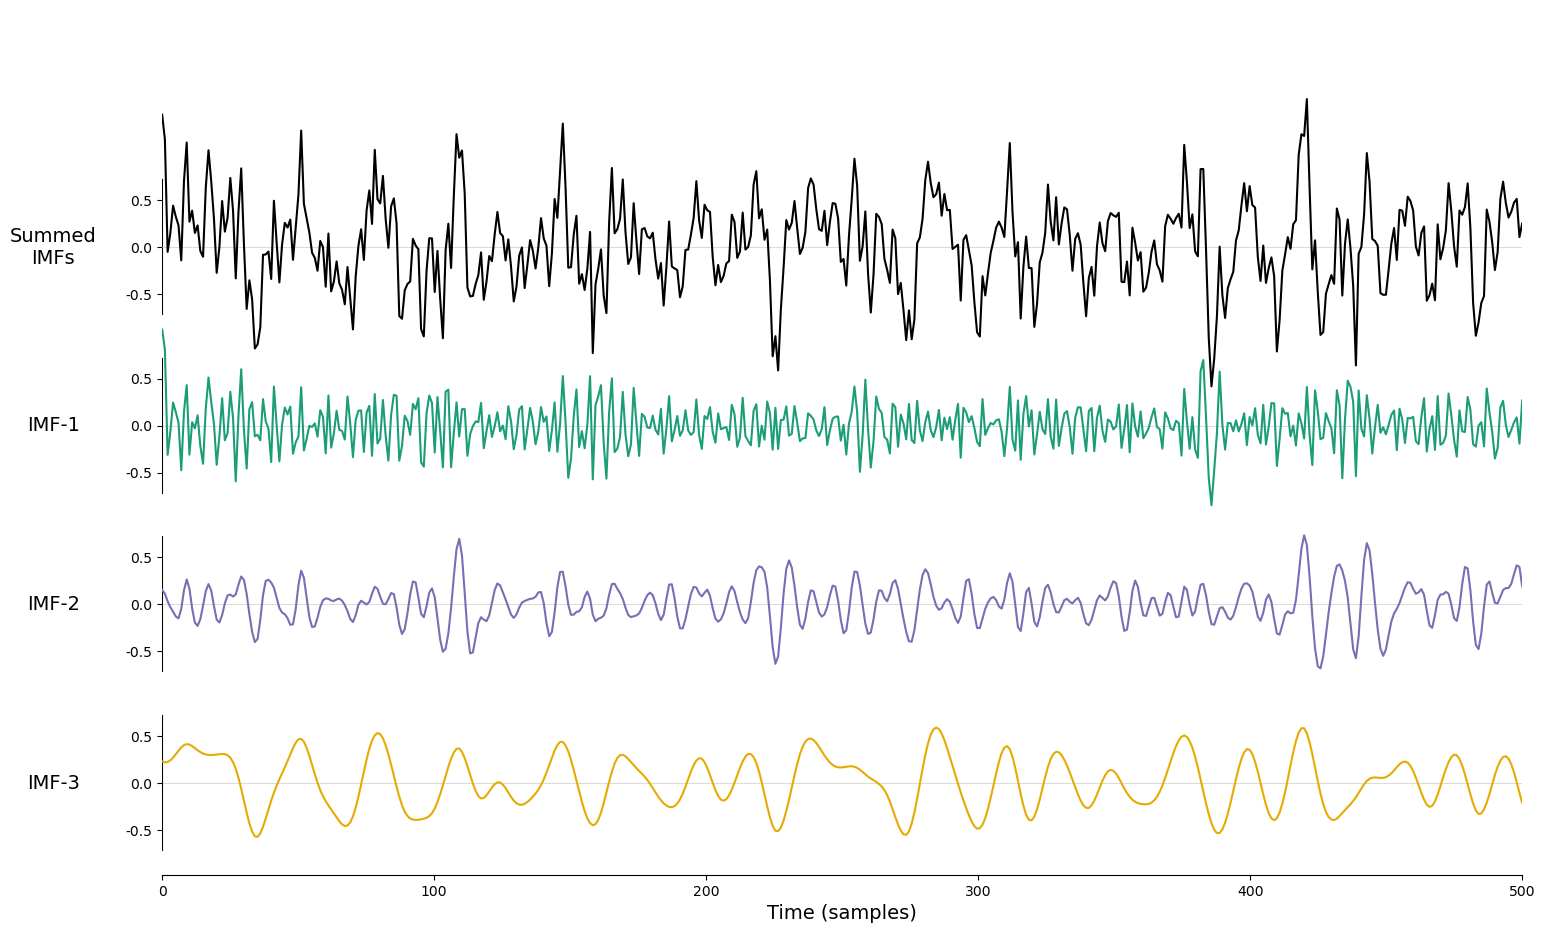

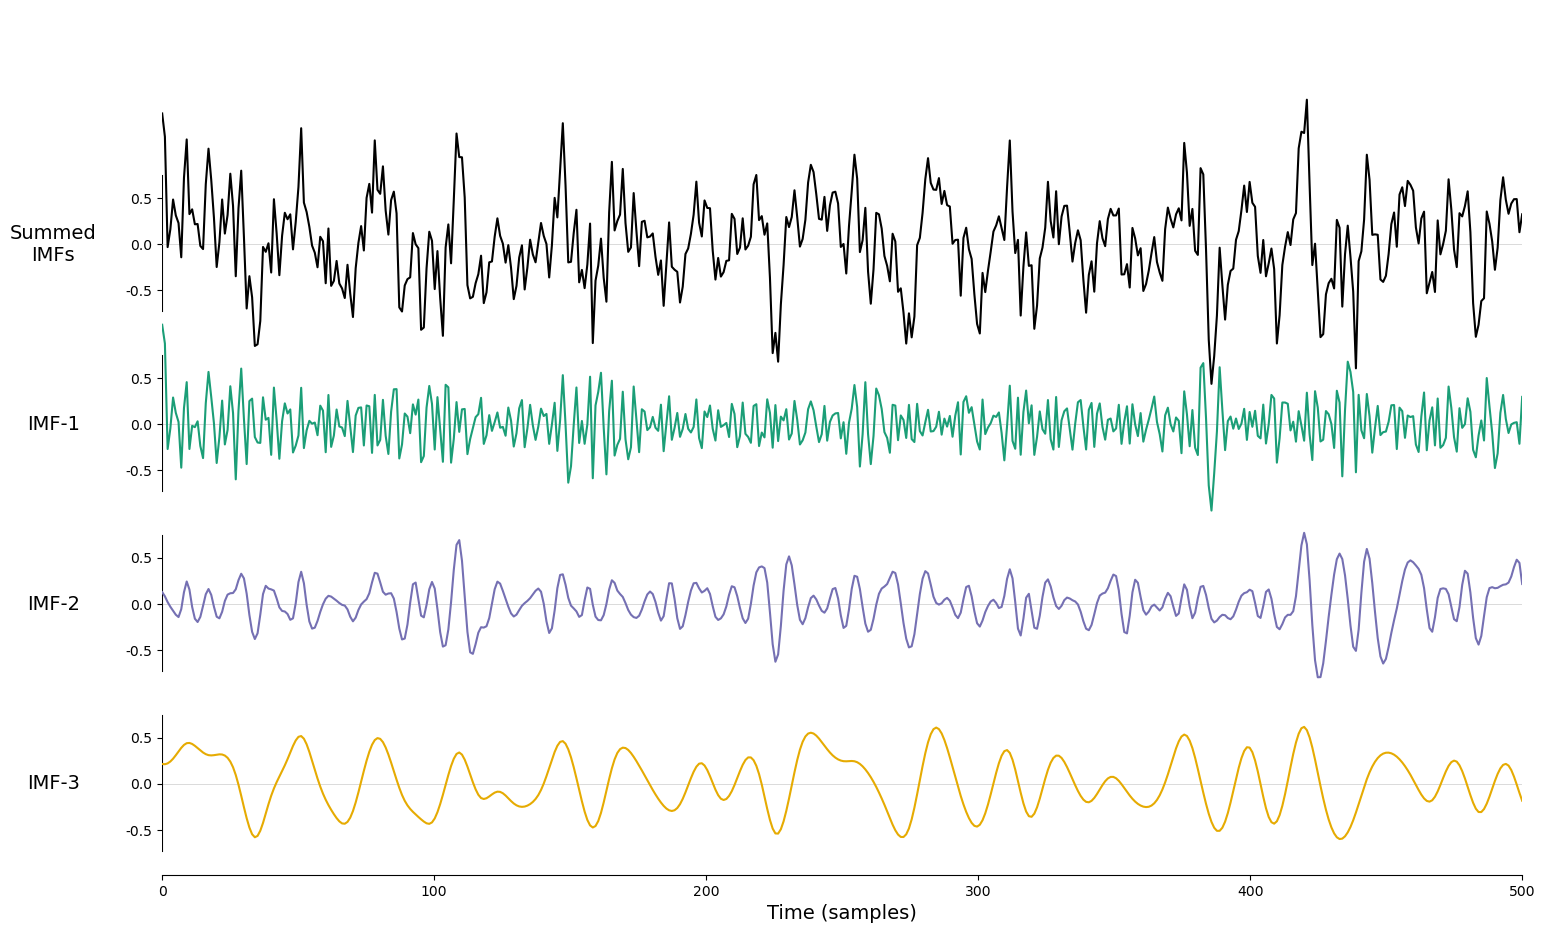

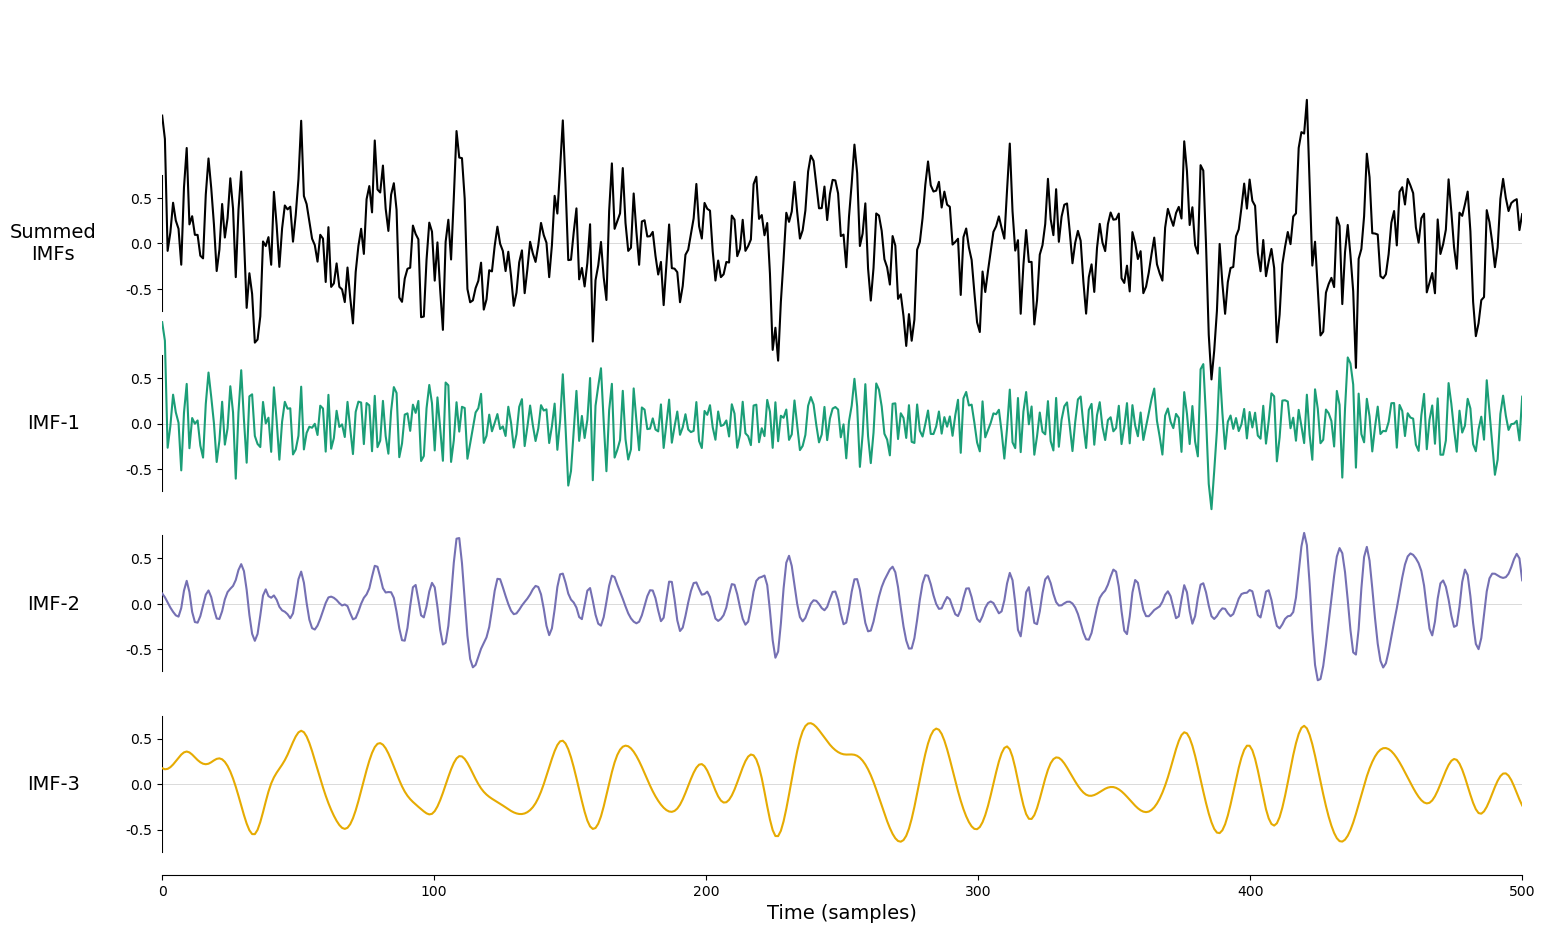

In [51]:
first_signal = ensemble_imfs[0]

for ensemble in first_signal:
    signal = ensemble["imfs"]
    print(ensemble["noise"])
    emd.plotting.plot_imfs(signal[:500,:3])

<Axes: xlabel='Time (samples)'>

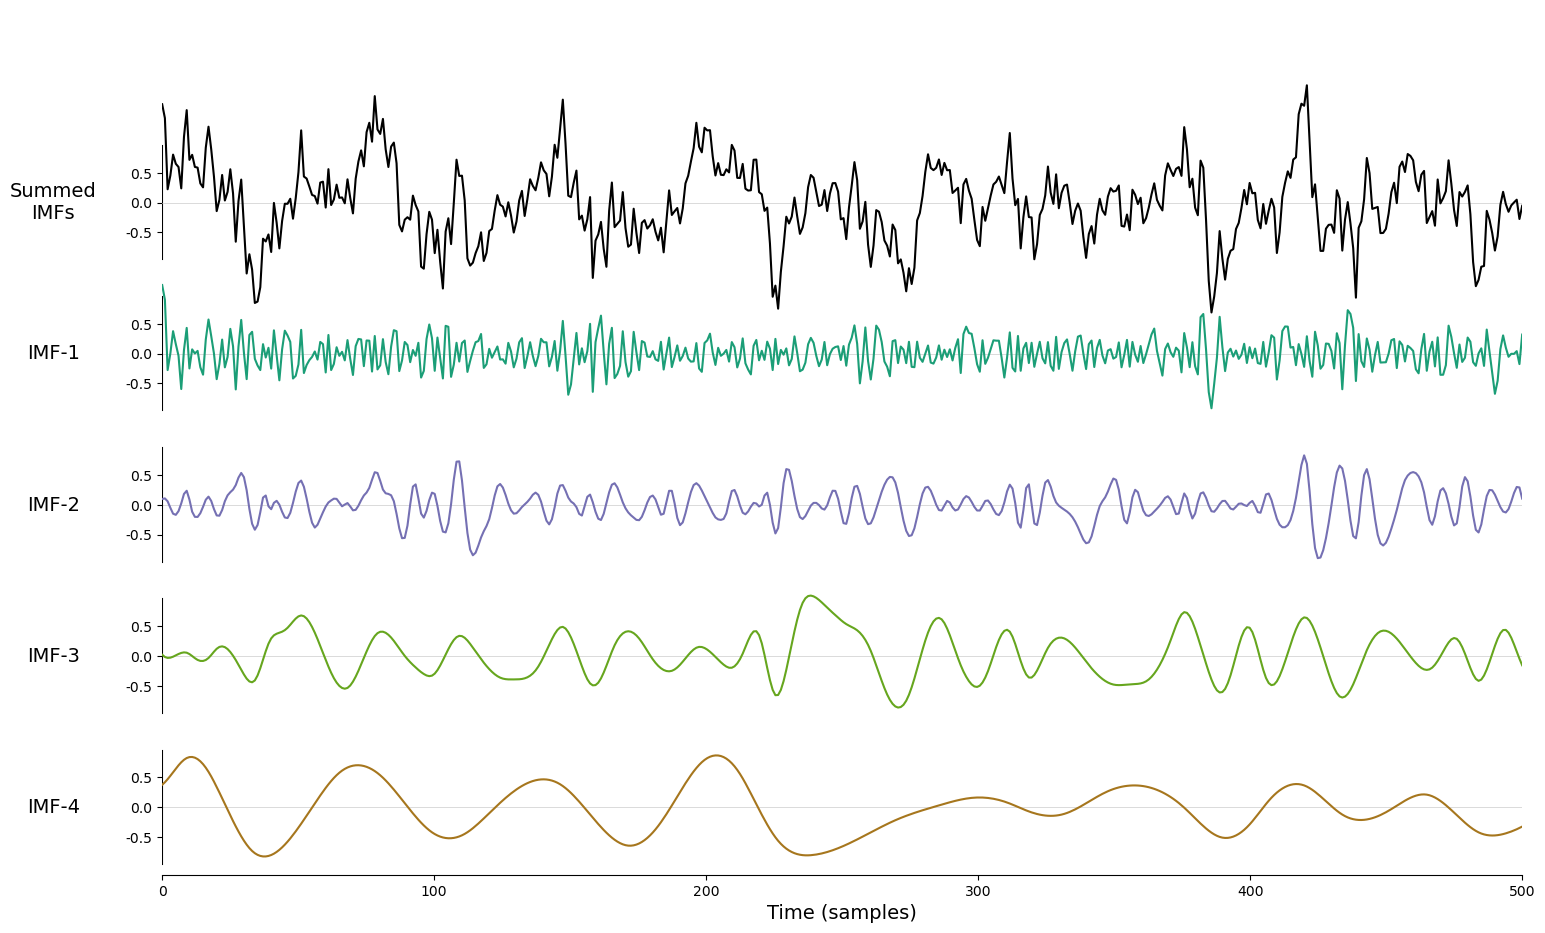

In [52]:
# Plotting the first signal's IMFS - channel FC5
imf = signal_imfs[0]
emd.plotting.plot_imfs(imf[:500,:4])

# Power Spectral Decomposition

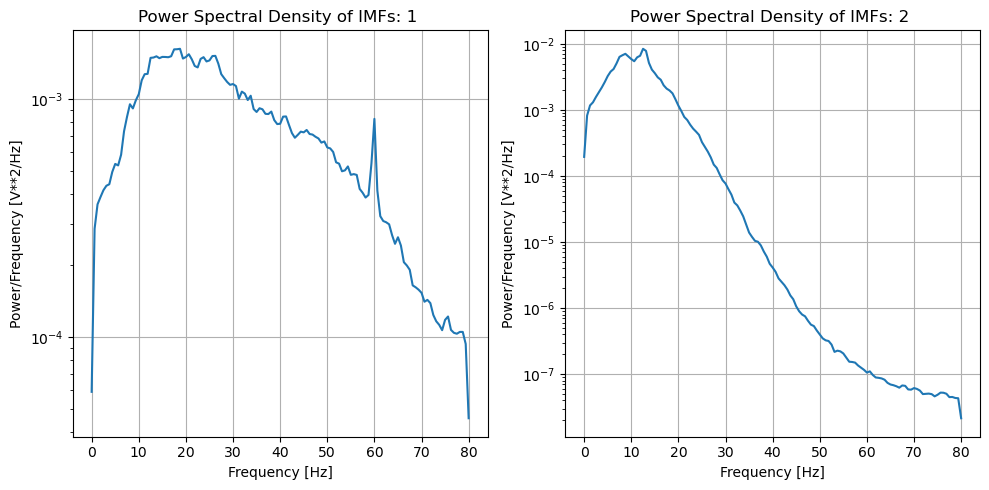

In [54]:
# Decide how many IMFs to keep - EMD

imf = signal_imfs[0]

from scipy.signal import welch
IMFS_TO_CHECK = 2
k=1
plt.figure(figsize=(10, 5))
for i in range(IMFS_TO_CHECK):
    imfs = imf[:, i]
    f, Pxx = welch(imfs, fs=160)
    plt.subplot(1,2,k)
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density of IMFs: {i+1} ')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power/Frequency [V**2/Hz]')
    plt.grid()
    plt.tight_layout()
    k = k + 1

plt.show()


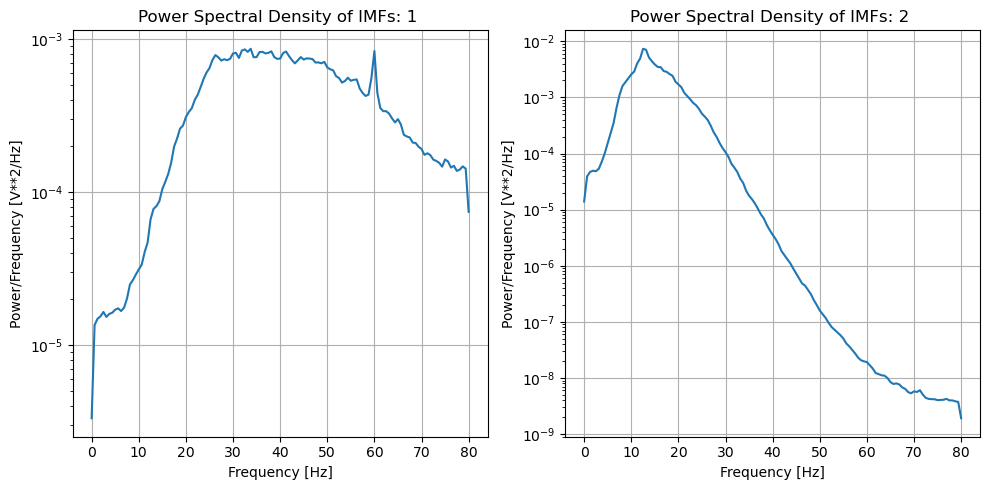

In [55]:
# Ensemble EMD - PSD
first_signal = ensemble_imfs[0]
first_signal = ensemble_imfs[0][0]["imfs"]
IMFS_TO_CHECK = 2
k=1
plt.figure(figsize=(10, 5))
for i in range(IMFS_TO_CHECK):
    imfs = first_signal[:, i]
    f, Pxx = welch(imfs, fs=160)
    plt.subplot(1,2,k)
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectral Density of IMFs: {i+1} ')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power/Frequency [V**2/Hz]')
    plt.grid()
    plt.tight_layout()
    k = k + 1

plt.show()

# Denoising

In [56]:
def choose_threshold(imf):
    noise_var = np.median(np.abs(imf)) / 0.6745
    threshold = noise_var * np.sqrt(2 * np.log(len(imf)))
    return threshold

def soft_threshold(y, T):
    if np.abs(y).all() > T:
        return np.sign(y)*(np.abs(y) - T)
    elif np.abs(y).all() <= T:
        return 0

def hard_threshold(y, T):
    if np.abs(y).all() > T:
        return y
    elif np.abs(y).all() <= T:
        return 0
def SCAD_threshold(y,T):
    z = 3.7 #Recommended based on Bayesian argument
    if np.abs(y).all() <= 2*T:
        return np.sign(y)*np.maximum(0, np.abs(y) - T)
    elif 2*T < np.abs(y).all() <= z*T:
        return ((z - 1)*(y-z*T)*np.sign(y))/z - 2
    elif np.abs(y).all() > z * T:
        return y

def threshold_imfs(imfs, method='soft', n_imfs=3):
    denoised_imfs = np.copy(imfs)
    
    for i in range(min(n_imfs, imfs.shape[1])):
        threshold = choose_threshold(imfs[:, i])
        if method == 'soft':
            denoised_imfs[: ,i] = soft_threshold(imfs[:, i], threshold)
        elif method == 'hard':
            denoised_imfs[:, i] = hard_threshold(imfs[:, i], threshold)
        elif method == 'scad':
            denoised_imfs[:, i] = SCAD_threshold(imfs[:, i], threshold)
    denoised_signal = np.sum(denoised_imfs, axis=1)
    return denoised_signal


In [57]:
results_emd = []
results_eemd = []

In [58]:
original_eeg_dataset = {
    "dataset_original": raw_eeg_dataset,
    "dataset_noisy": noisy_eeg_dataset,
}

### Standard EMD Denoising - IMF Removal

In [59]:
# EMD
IMFS_TO_REMOVE = 2
for n_imfs in range(1,IMFS_TO_REMOVE+1):
    denoised_dict = {
        "parameter_sets": [],
        "denoised_signals": [],
    }
    for signal in signal_imfs:
        reconstructed_signal = np.sum(signal[:,n_imfs:],axis=1)
        denoised_dict["parameter_sets"].append(n_imfs)
        denoised_dict["denoised_signals"].append(reconstructed_signal)
    results_emd.append(denoised_dict)

In [60]:
# EEMD
IMFS_TO_REMOVE = 1

signals = []
for signal in ensemble_imfs:
    denoised_dict = {
        "parameter_sets": [],
        "denoised_signals": [],
    }
    for comb in signal: 
        imfs = comb["imfs"]
        param = comb["noise"]
        # Corrected line:
        reconstructed_signal = np.sum(imfs[:, IMFS_TO_REMOVE:], axis=1)
        denoised_dict["parameter_sets"].append(param)
        denoised_dict["denoised_signals"].append(reconstructed_signal)
    signals.append(denoised_dict)
results_eemd.append(signals)

### Thresholding IMFs

In [61]:
results_emd_threshold = []
results_eemd_threshold = []
THRESH = 1
METHOD = 'hard'
methods = ['soft', 'hard', 'scad']

In [62]:
for signal in signal_imfs:
    signal_results = {}
    for method in methods:
        reconstructed_signal = threshold_imfs(signal, method = method, n_imfs=THRESH)
        signal_results[method] = reconstructed_signal
    results_emd_threshold.append(signal_results)

In [63]:
results_emd_threshold[0]

{'soft': array([-1.28998838, -1.28114982, -1.29844043, ..., -0.43762144,
        -0.45408966, -0.46928663]),
 'hard': array([-1.28998838, -1.28114982, -1.29844043, ..., -0.43762144,
        -0.45408966, -0.46928663]),
 'scad': array([-1.14944438, -1.28114982, -1.29844043, ..., -0.43762144,
        -0.45408966, -0.46928663])}

In [64]:
for signal in ensemble_imfs:
    signal_dict = {}
    for comb in signal:
        param = comb["noise"]
        imfs = comb["imfs"]
        if param not in signal_dict:
            signal_dict[param] = {}
        for method in methods:
            reconstructed_signal = threshold_imfs(imfs, method=method, n_imfs=THRESH)
            signal_dict[param][method] = reconstructed_signal
    results_eemd_threshold.append(signal_dict)

In [65]:
len(results_eemd_threshold)

64

In [68]:
match noise:
    case 'pink':
        data_path = "C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/data/eeg_dataset_pink.pkl"
    case 'burst':
        data_path = "C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/data/eeg_dataset_burst.pkl" 
    case 'gaussian':
        data_path = "C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/data/eeg_dataset.pkl" 

with open(data_path, "wb") as f:
    pickle.dump({"results_emd_denoising": results_emd,
                  "results_eemd_denoising": results_eemd,
                    "original_eeg": original_eeg_dataset,
                    "results_emd_threshold": results_emd_threshold,
                    "results_eemd_threshold": results_eemd_threshold}, f)